## Project on Deep Learning

In [4]:
!pip install face-alignment

In [0]:
import face_alignment
import numpy as np
from skimage import io
from PIL import Image
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import collections
from tqdm.notebook import tqdm
import random
from PIL import Image, ImageDraw

from skimage.transform import resize
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt

### Importing HeadPoseImageDatabase

In [0]:
images = glob.glob('/content/drive/My Drive/Skoltech/Deep Learning/HeadPoseImageDatabase/*/*.jpg')

In [0]:
def get_point(point1, point2, len_from_p1=0.5):
    """
    point1, point2 - points coordinates as tuples
    """
    x_coord = point1[0] + (point2[0] - point1[0]) * len_from_p1
    y_coord = point1[1] + (point2[1] - point1[1]) * len_from_p1

    return [x_coord, y_coord, 0]

### Figuring out how to better use euristic model

In [0]:
# Run the 3D face alignment on a test image, without CUDA.
def plot_facial_landmarks(input_path, part='both', wears='correct'):
    fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, device='cuda', flip_input=True)

    try:
        input_img = io.imread(input_path)
    except FileNotFoundError:
        input_img = io.imread('test/assets/aflw-test.jpg')

    preds = fa.get_landmarks(input_img)[-1]

    # 2D-Plot
    plot_style = dict(marker='o',
                      markersize=4,
                      linestyle='-',
                      lw=2)

    pred_type = collections.namedtuple('prediction_type', ['slice', 'color'])
    pred_types = {'face': pred_type(slice(0, 17), (0.682, 0.780, 0.909, 0.5)),
                  'eyebrow1': pred_type(slice(17, 22), (1.0, 0.498, 0.055, 0.4)),
                  'eyebrow2': pred_type(slice(22, 27), (1.0, 0.498, 0.055, 0.4)),
                  'nose': pred_type(slice(27, 31), (0.345, 0.239, 0.443, 0.4)),
                  'nostril': pred_type(slice(31, 36), (0.345, 0.239, 0.443, 0.4)),
                  'eye1': pred_type(slice(36, 42), (0.596, 0.875, 0.541, 0.3)),
                  'eye2': pred_type(slice(42, 48), (0.596, 0.875, 0.541, 0.3)),
                  'lips': pred_type(slice(48, 60), (0.596, 0.875, 0.541, 0.3)),
                  'teeth': pred_type(slice(60, 68), (0.596, 0.875, 0.541, 0.4))
                  }

    fig = plt.figure(figsize=plt.figaspect(.3))
    ax = fig.add_subplot(1,3,1)
    ax.imshow(input_img)

    for pred_type in pred_types.values():
        ax.plot(preds[pred_type.slice, 0],
                preds[pred_type.slice, 1],
                color=pred_type.color, **plot_style)

    ax.axis('off')

    # 3D-Plot
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    surf = ax.scatter(preds[:, 0] * 1.2,
                      preds[:, 1],
                      preds[:, 2],
                      c='cyan',
                      alpha=1.0,
                      edgecolor='b')

    for pred_type in pred_types.values():
        ax.plot3D(preds[pred_type.slice, 0] * 1.2,
                  preds[pred_type.slice, 1],
                  preds[pred_type.slice, 2], color='blue')
        
    ax.view_init(elev=90., azim=90.)
    ax.set_xlim(ax.get_xlim()[::-1])

    ax = fig.add_subplot(1, 3, 3)

    for pred_type in pred_types.values():
        ax.plot(preds[pred_type.slice, 0],
                preds[pred_type.slice, 1],
                color=pred_type.color, **plot_style)
        
    # Adding extra points for mask alignment 69,70 - left, 71,72 - right
    
    # preds = np.append()

    

    if wears == 'correct':
      #left part
        preds = np.append(preds, [get_point(preds[31], preds[39], 0.6)], axis=0) #68
        preds = np.append(preds, [get_point(preds[4], preds[36], 0.7)], axis=0) #69
        lx = list(preds[[4,5,6,7,8,57,30,29,28,68,69], 0])
        ly = list(preds[[4,5,6,7,8,57,30,29,28,68,69], 1])
      #right part
        preds = np.append(preds, [get_point(preds[35], preds[42], 0.6)], axis=0) #70
        preds = np.append(preds, [get_point(preds[12], preds[45], 0.7)], axis=0) #71
        rx = list(preds[[12,11,10,9,8,57,30,29,28,70,71], 0])
        ry = list(preds[[12,11,10,9,8,57,30,29,28,70,71], 1])

      #detect if the face is rotated too_much
      #Rotation to the right

        if preds[30][0] > preds[9][0]:
          #detect severe rotation to the right
            # if preds[70][0]

            if preds[70][0] < preds[28][0]:
                part = 'left'
                lx, ly = list(preds[[4,5,6,7,8,57,30,29,28,68,69], 0]), list(preds[[4,5,6,7,8,57,30,29,28,68,69], 1])
            else:
                # preds = np.append(preds, [get_point(preds[54], preds[45], 0.5)], axis=0) #72  
                koef = 0.6
                preds = np.append(preds, [[preds[30][0]+(preds[42][0] - preds[39][0])*koef, preds[30][1], preds[30][2]]], axis=0) #72 
                preds = np.append(preds, [[preds[57][0]+(preds[42][0] - preds[39][0])*koef, preds[57][1], preds[57][2]]], axis=0) #73 
                preds = np.append(preds, [[preds[71][0]+(preds[42][0] - preds[39][0])*0.3, preds[71][1], preds[71][2]]], axis=0) #74 

                lx, ly = list(preds[[4,5,6,7,8,57,30,29,28,68,69], 0]), list(preds[[4,5,6,7,8,57,30,29,28,68,69], 1])
                rx, ry = list(preds[[8,9,73,72,74,70,28,29,30,57], 0]), list(preds[[8,9,73,72,74,70,28,29,30,57], 1])

          #And to the left
        if preds[30][0] <= preds[7][0]:
            if preds[68][0] - (1.05*preds[68][0]-preds[68][0]) > preds[28][0]:
                part = 'right'
                rx, ry = list(preds[[12,11,10,9,8,57,30,29,28,70,71], 0]), list(preds[[12,11,10,9,8,57,30,29,28,70,71], 1])
            else:
                koef = 0.65
                preds = np.append(preds, [[preds[30][0]-(preds[42][0] - preds[39][0])*koef, preds[30][1], preds[30][2]]], axis=0) #72 
                preds = np.append(preds, [[preds[57][0]-(preds[42][0] - preds[39][0])*koef, preds[57][1], preds[57][2]]], axis=0) #73 
                preds = np.append(preds, [[preds[69][0]-(preds[42][0] - preds[39][0])*0.3, preds[69][1], preds[69][2]]], axis=0) #74 
                lx, ly = list(preds[[8,7,73,72,74,68,28,29,30,57], 0]), list(preds[[8,7,73,72,74,68,28,29,30,57], 1])
                rx, ry = list(preds[[12,11,10,9,8,57,30,29,28,70,71], 0]), list(preds[[12,11,10,9,8,57,30,29,28,70,71], 1])

        if part == 'both':
            ax.fill(lx,ly, 'b')
            ax.fill(rx,ry, 'r')

        elif part =='left':
            ax.fill(lx,ly, 'b')

        elif part =='right':
            ax.fill(rx,ry, 'r')

    if wears == 'incorrect':

        if part == 'both':
            lx = list(preds[[2,3,4,5,6,7,8,30,29,28], 0])
            ly = list(preds[[2,3,4,5,6,7,8,30,29,28], 1])
            ax.fill(lx,ly, 'b')
            rx = list(preds[[13,12,11,10,9,8,30,29,28], 0])
            ry = list(preds[[13,12,11,10,9,8,30,29,28], 1])
            ax.fill(rx,ry, 'r')

        elif part =='left':
            lx = list(preds[[4,5,6,7,8,33,39,36], 0])
            ly = list(preds[[4,5,6,7,8,33,39,36], 1])
            ax.fill(lx,ly, 'b')

        elif part =='right':
            rx = list(preds[[13,12,11,10,9,8,30,29,28], 0])
            ry = list(preds[[13,12,11,10,9,8,30,29,28], 1])
            ax.fill(rx,ry, 'r')


    ax.set_xlim(ax.get_xlim()[::-1])
    ax.invert_xaxis()
    ax.invert_yaxis()
    
    plt.show()
    return preds

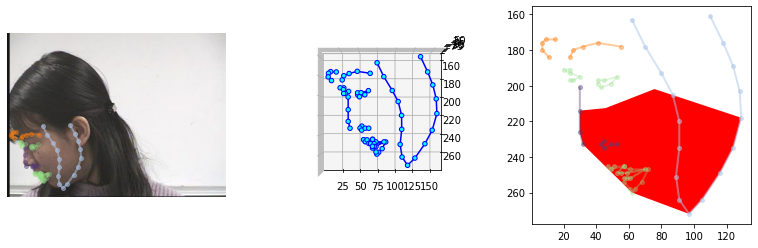

In [398]:
preds = plot_facial_landmarks(images[7])

### Code for generating correctly worn mask, using simple euristics



In [0]:
# Run the 3D face alignment on a test image, without CUDA.
def plot_facial_landmarks_correct(input_path, subset, part='both'):
    fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, device='cuda', flip_input=True)

    try:
        input_img = io.imread(input_path)
        fname= input_path.split('/')[-1][:-4]
    except FileNotFoundError:
        print('no_file')

    preds = fa.get_landmarks(input_img)[-1]

    # 2D-Plot
    plot_style = dict(marker='o',
                      markersize=4,
                      linestyle='-',
                      lw=2)

    pred_type = collections.namedtuple('prediction_type', ['slice', 'color'])
    pred_types = {'face': pred_type(slice(0, 17), (0.682, 0.780, 0.909, 0.5)),
                  'eyebrow1': pred_type(slice(17, 22), (1.0, 0.498, 0.055, 0.4)),
                  'eyebrow2': pred_type(slice(22, 27), (1.0, 0.498, 0.055, 0.4)),
                  'nose': pred_type(slice(27, 31), (0.345, 0.239, 0.443, 0.4)),
                  'nostril': pred_type(slice(31, 36), (0.345, 0.239, 0.443, 0.4)),
                  'eye1': pred_type(slice(36, 42), (0.596, 0.875, 0.541, 0.3)),
                  'eye2': pred_type(slice(42, 48), (0.596, 0.875, 0.541, 0.3)),
                  'lips': pred_type(slice(48, 60), (0.596, 0.875, 0.541, 0.3)),
                  'teeth': pred_type(slice(60, 68), (0.596, 0.875, 0.541, 0.4))
                  }

    # fig = plt.figure()
    # plt.imshow(input_img)

    # plt.axis('off')
    # Adding extra points for mask alignment 69,70 - left, 71,72 - right
    
    # preds = np.append()    

    
    preds = np.append(preds, [get_point(preds[31], preds[39], 0.6)], axis=0) #68
    preds = np.append(preds, [get_point(preds[4], preds[36], 0.7)], axis=0) #69
    preds = np.append(preds, [get_point(preds[35], preds[42], 0.6)], axis=0) #70
    preds = np.append(preds, [get_point(preds[12], preds[45], 0.7)], axis=0) #71

    if preds[30][0] >= preds[8][0]-(preds[42][0] - preds[39][0])*0.2 and preds[30][0] <= preds[8][0]+(preds[42][0] - preds[39][0])*0.2:
        if preds[17][1] > preds[2][1]:
            # print(0)
            preds[5] = [preds[5][0]-(preds[42][0] - preds[39][0])*0.22, preds[5][1], preds[5][2]]
            preds[4] = [preds[4][0]-(preds[42][0] - preds[39][0])*0.15, preds[4][1], preds[4][2]]
            preds[6] = [preds[6][0]-(preds[42][0] - preds[39][0])*0.1, preds[6][1], preds[6][2]]
            preds[11] = [preds[11][0]+(preds[42][0] - preds[39][0])*0.22, preds[11][1], preds[11][2]]
            preds[12] = [preds[12][0]+(preds[42][0] - preds[39][0])*0.15, preds[12][1], preds[12][2]]
            preds[10] = [preds[10][0]+(preds[42][0] - preds[39][0])*0.1, preds[10][1], preds[10][2]]     

  #left        
    lx = list(preds[[4,5,6,7,8,57,30,29,28,68,69], 0])
    ly = list(preds[[4,5,6,7,8,57,30,29,28,68,69], 1])
  #right
    rx = list(preds[[12,11,10,9,8,57,30,29,28,70,71], 0])
    ry = list(preds[[12,11,10,9,8,57,30,29,28,70,71], 1])

  #detect if the face is rotated too_much
  #Rotation to the right

    if preds[30][0] > preds[8][0]+(preds[42][0] - preds[39][0])*0.2:
      #detect severe rotation to the right
        if preds[70][0] + 0.05*(preds[70][0]-preds[28][0]) < preds[28][0]:
            part = 'left'
            # print(1)
            preds[57] = [preds[57][0]+(preds[42][0] - preds[39][0])*0.55, preds[57][1], preds[57][2]]
            preds[8] = [preds[8][0]+(preds[42][0] - preds[39][0])*0.6, preds[8][1], preds[8][2]]
            preds[30] = [preds[30][0]+(preds[42][0] - preds[39][0])*0.3, preds[30][1], preds[30][2]]
            preds[28] = [preds[28][0]+(preds[42][0] - preds[28][0])*0.4, preds[28][1], preds[28][2]]
            lx, ly = list(preds[[4,5,6,7,8,57,30,28,68,69], 0]), list(preds[[4,5,6,7,8,57,30,28,68,69], 1])

        elif preds[30][0]>preds[12][0]:
            koef = 0.6
            # print(2)
            preds = np.append(preds, [[preds[30][0]+(preds[42][0] - preds[39][0])*0.75, preds[30][1], preds[30][2]]], axis=0) #72 
            preds = np.append(preds, [[preds[57][0]+(preds[42][0] - preds[39][0])*0.7, preds[57][1], preds[57][2]]], axis=0) #73 
            preds = np.append(preds, [[preds[71][0]+(preds[42][0] - preds[39][0])*0.3, preds[71][1], preds[71][2]]], axis=0) #74 

            lx, ly = list(preds[[4,5,6,7,8,57,30,29,28,68,69], 0]), list(preds[[4,5,6,7,8,57,30,29,28,68,69], 1])
            rx, ry = list(preds[[8,9,73,72,74,70,28,29,30,57], 0]), list(preds[[8,9,73,72,74,70,28,29,30,57], 1])

        elif preds[30][0]<preds[9][0]:
            # print(3)
            preds = np.append(preds, [[preds[30][0]+(preds[42][0] - preds[39][0])*1.2, preds[30][1], preds[30][2]]], axis=0) #72 
            preds = np.append(preds, [[preds[57][0]+(preds[42][0] - preds[39][0])*1, preds[57][1], preds[57][2]]], axis=0) #73 
            preds = np.append(preds, [[preds[71][0]+(preds[42][0] - preds[39][0])*0.45, preds[71][1], preds[71][2]]], axis=0) #74 

            lx, ly = list(preds[[4,5,6,7,8,57,30,29,28,68,69], 0]), list(preds[[4,5,6,7,8,57,30,29,28,68,69], 1])
            rx, ry = list(preds[[8,9,73,72,74,70,28,29,30,57], 0]), list(preds[[8,9,73,72,74,70,28,29,30,57], 1])

        else:
            koef = 0.75
            # print(4)
            preds = np.append(preds, [[preds[30][0]+(preds[42][0] - preds[39][0])*0.8, preds[30][1], preds[30][2]]], axis=0) #72 
            preds = np.append(preds, [[preds[57][0]+(preds[42][0] - preds[39][0])*0.6, preds[57][1], preds[57][2]]], axis=0) #73 
            preds = np.append(preds, [[preds[71][0]+(preds[42][0] - preds[39][0])*0.3, preds[71][1], preds[71][2]]], axis=0) #74 

            lx, ly = list(preds[[4,5,6,7,8,57,30,29,28,68,69], 0]), list(preds[[4,5,6,7,8,57,30,29,28,68,69], 1])
            rx, ry = list(preds[[8,9,73,72,74,70,28,29,30,57], 0]), list(preds[[8,9,73,72,74,70,28,29,30,57], 1])

      #And to the left
    if preds[30][0] < preds[8][0]-(preds[42][0] - preds[39][0])*0.2:
        if preds[68][0] - 0.05*(preds[68][0]-preds[28][0]) > preds[28][0]:
            part = 'right'
            # print(5)
            preds[56] = [preds[56][0]-(preds[42][0] - preds[39][0])*0.6, preds[56][1], preds[56][2]]
            preds[8] = [preds[8][0]-(preds[42][0] - preds[39][0])*0.6, preds[8][1], preds[8][2]]
            preds[30] = [preds[30][0]-(preds[42][0] - preds[39][0])*0.5, preds[30][1], preds[30][2]]
            preds[28] = [preds[28][0]-(preds[42][0] - preds[28][0])*0.3, preds[28][1], preds[28][2]]
            rx, ry = list(preds[[12,11,10,9,8,56,30,28,70,71], 0]), list(preds[[12,11,10,9,8,56,30,28,70,71], 1])

        elif preds[30][0] < preds[3][0]:
            koef = 0.65
            # print(6)
            preds = np.append(preds, [[preds[30][0]-(preds[42][0] - preds[39][0])*0.8, preds[30][1], preds[30][2]]], axis=0) #72 
            preds = np.append(preds, [[preds[56][0]-(preds[42][0] - preds[39][0])*0.9, preds[56][1], preds[56][2]]], axis=0) #73 
            preds = np.append(preds, [[preds[69][0]-(preds[42][0] - preds[39][0])*0.5, preds[69][1], preds[69][2]]], axis=0) #74 
            lx, ly = list(preds[[8,7,73,72,74,68,28,29,30,56], 0]), list(preds[[8,7,73,72,74,68,28,29,30,56], 1])
            rx, ry = list(preds[[12,11,10,9,8,56,30,29,28,70,71], 0]), list(preds[[12,11,10,9,8,56,30,29,28,70,71], 1])

        elif preds[30][0] > preds[7][0]:
            # print(7)
            preds = np.append(preds, [[preds[30][0]-(preds[42][0] - preds[39][0])*1.05, preds[30][1], preds[30][2]]], axis=0) #72 
            preds = np.append(preds, [[preds[56][0]-(preds[42][0] - preds[39][0])*0.8, preds[56][1], preds[56][2]]], axis=0) #73 
            preds = np.append(preds, [[preds[69][0]-(preds[42][0] - preds[39][0])*0.45, preds[69][1], preds[69][2]]], axis=0) #74 
            lx, ly = list(preds[[8,7,73,72,74,68,28,29,30,56], 0]), list(preds[[8,7,73,72,74,68,28,29,30,56], 1])
            rx, ry = list(preds[[12,11,10,9,8,56,30,29,28,70,71], 0]), list(preds[[12,11,10,9,8,56,30,29,28,70,71], 1])
        else:
            koef = 0.8
            # print(8)
            preds = np.append(preds, [[preds[30][0]-(preds[42][0] - preds[39][0])*0.9, preds[30][1], preds[30][2]]], axis=0) #72 
            preds = np.append(preds, [[preds[56][0]-(preds[42][0] - preds[39][0])*0.9, preds[56][1], preds[56][2]]], axis=0) #73 
            preds = np.append(preds, [[preds[69][0]-(preds[42][0] - preds[39][0])*0.4, preds[69][1], preds[69][2]]], axis=0) #74 
            lx, ly = list(preds[[8,7,73,72,74,68,28,29,30,56], 0]), list(preds[[8,7,73,72,74,68,28,29,30,56], 1])
            rx, ry = list(preds[[12,11,10,9,8,56,30,29,28,70,71], 0]), list(preds[[12,11,10,9,8,56,30,29,28,70,71], 1])

    original = Image.open(input_path)
    im = Image.open(input_path)
    draw = ImageDraw.Draw(im)
    mask = Image.new('RGB', im.size, (0,0,0))
    erase = ImageDraw.Draw(mask)

    if part == 'both':
        lxy = [(x,y) for x,y in zip(lx,ly)]
        rxy = [(x,y) for x,y in zip(rx,ry)]
        erase.polygon(lxy, outline=(255,255,255), fill=(255,255,255))
        erase.polygon(rxy, outline=(255,255,255), fill=(255,255,255))
        draw.polygon(lxy, outline=(0,0,0), fill=(0,0,0))
        draw.polygon(rxy, outline=(0,0,0), fill=(0,0,0))

    elif part =='left':
        lxy = [(x,y) for x,y in zip(lx,ly)]
        erase.polygon(lxy, outline=(255,255,255), fill=(255,255,255))
        draw.polygon(lxy, outline=(0,0,0), fill=(0,0,0))

    elif part =='right':
        rxy = [(x,y) for x,y in zip(rx,ry)]
        erase.polygon(rxy, outline=(255,255,255), fill=(255,255,255))
        draw.polygon(rxy, outline=(0,0,0), fill=(0,0,0))

    del draw
    del erase

    # write to stdout
    mask = mask.convert('L')
    mask.save("/content/drive/My Drive/Skoltech/Deep Learning/Project/dataset_for_segm/mask/{}/{}.png".format(subset, fname))
    im.save("/content/drive/My Drive/Skoltech/Deep Learning/Project/dataset_for_segm/masked/{}/{}.png".format(subset, fname))
    original.save("/content/drive/My Drive/Skoltech/Deep Learning/Project/dataset_for_segm/image/{}/{}.png".format(subset, fname))
    # plt.show()
    return mask

### Selecting only part of images from head pose image dataset

In [0]:
random.shuffle(images)

In [299]:
# textures = dict()
# textures[1] = io.imread('/content/drive/My Drive/Deep Learning/textures/1.png')[:,:,:-1]
# textures[2] = io.imread('/content/drive/My Drive/Deep Learning/textures/2.png')[:,:,:-1]
# textures[3] = io.imread('/content/drive/My Drive/Deep Learning/textures/3.png')[:,:,:-1]
rolls = ['test','train','val']
for filepath in tqdm(images[:500]):
    try:
        roll = np.random.choice(rolls, p=[0.15, 0.7, 0.15])
        fname = filepath.split('/')[-1][:-4]
        mask = plot_facial_landmarks_correct(filepath, roll)
    except Exception as e:
        print(e)

'NoneType' object is not subscriptable



In [307]:
import os
all_files = glob.glob("/content/drive/My Drive/Skoltech/Deep Learning/Project/dataset_for_segm/*[mask,image]/*/*.png")
valid = [x.split('/')[-1] for x in glob.glob("/content/drive/My Drive/Skoltech/Deep Learning/Project/dataset_for_segm/masked/*/*.png")]
for filename in tqdm(all_files):
    fname = filename.split('/')[-1]
    if fname not in valid:
        os.remove(filename)